# PGD Attack and Binary Input Detector Using CIFAR10

This notebook shows the PGD attack implmentation using the ART library against deep learning models trained on MNIST-10 dataset. The notebook covers the following:

* Load the required libariries
* Load the dataset and inspect the data
* Create a deep learning model
* Train and evaluate the deep learning model on CIFAR test data
* Create an ART Keras classifier.
* Implement PGD attack using ART
* Create adversarial samples using the PDG attack
* Evaluate the deep leaarning model against the adversaarial samples
* Create a detector model to detect adversarial samples
* Train and evaluate the detector model

## Install and import required Libraries

In [1]:
# Install prerequired libraries.
# !pip install adversarial-robustness-toolbox

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
# import pandas as pd

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.detector.evasion import BinaryInputDetector

2024-05-15 14:11:15.651899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 14:11:15.727950: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load MNIST dataset

In [4]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = np.load('./../datasets/mnist10_dataset.npy', allow_pickle = True)
x_train, x_test = x_train / 255.0, x_test/ 255.0
min = x_train.min()
max = x_train.max()
x_train.shape, y_train.shape, x_test.shape, y_test.shape, min, max

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), 0.0, 1.0)

## Inpect the data


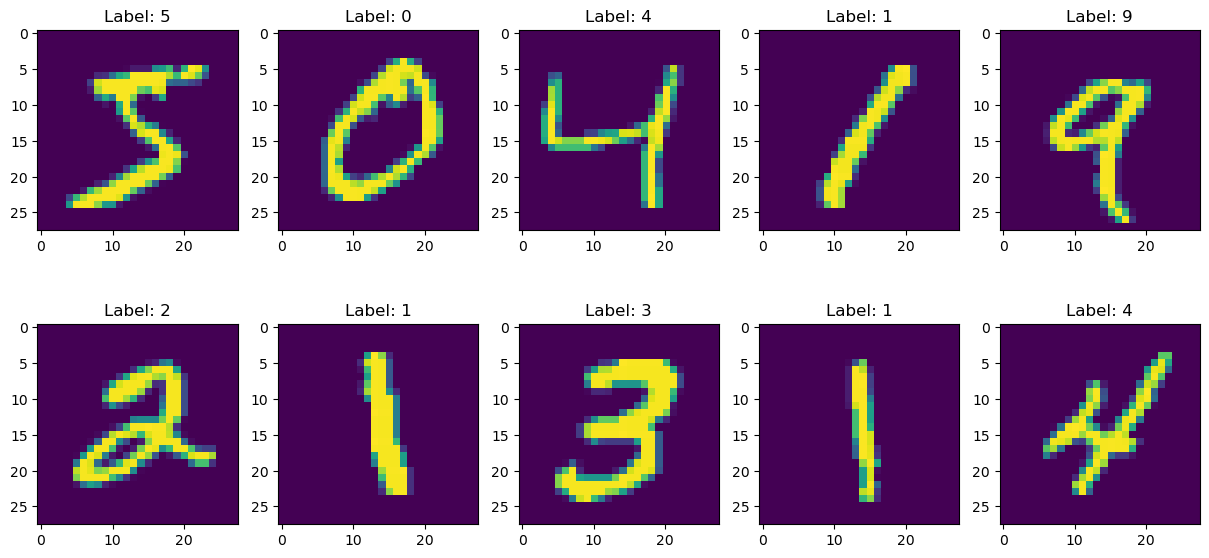

In [5]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()

for i, (image, label) in enumerate(zip(x_train[:10], y_train[:10])):
  im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Label: {label}",  fontsize=12)

In [6]:
nb_classes =10
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_classes)
x_test = np.expand_dims(x_test, axis=-1)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_classes)
x_train = np.expand_dims(x_train, axis=-1)

## TensorFlow with Keras API

Create a model using Keras API. Here we use the Keras Sequential model and add a sequence of layers. Afterwards the model is compiles with optimizer, loss function and metrics.

In [7]:
model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

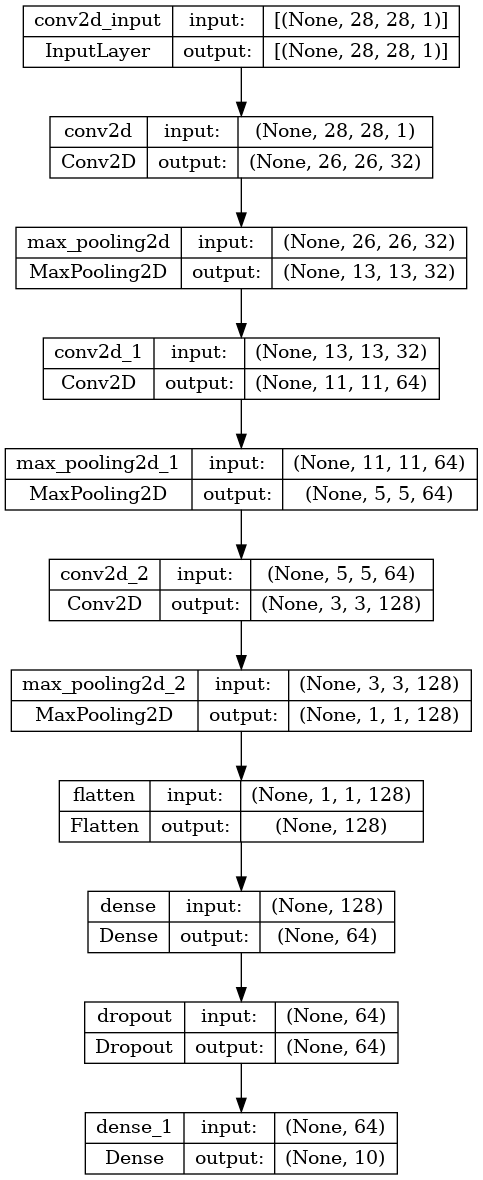

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Training the model

In [10]:
history = model.fit(x_train, y_train, epochs = 3)

Train on 60000 samples


2024-05-15 14:13:07.571700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 14:13:07.829440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22171 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-05-15 14:13:07.830151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43869 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:73:00.0, compute capability: 7.5
2024-05-15 14:13:07.854399: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimizati

Epoch 1/3


2024-05-15 14:13:08.204181: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/dense_1/bias/v/Assign' id:434 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_1/bias/v, training/Adam/dense_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-15 14:13:08.380977: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902


60000/60000 [==============================] - 5s 75us/sample - loss: 0.2392 - accuracy: 0.9243
Epoch 2/3
60000/60000 [==============================] - 4s 64us/sample - loss: 0.0811 - accuracy: 0.9765
Epoch 3/3
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0590 - accuracy: 0.9821


## Evaluate model accuracy on test data.

In [11]:
# model.save('./../models/mnist10_conv.keras')
model = tf.keras.models.load_model('./../models/mnist10_conv.keras')
model.summary()

2024-05-15 14:13:31.109078: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_2_1/kernel/Assign' id:592 op device:{requested: '', assigned: ''} def:{{{node conv2d_2_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_2_1/kernel, conv2d_2_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-15 14:13:31.276714: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/bias/v/Assign' id:906 op device:{requested: '', assigned: ''} def:{{{node dense_2/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/bias/v, dense_2/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

In [12]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2024-05-15 14:13:39.920902: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_1/mul' id:780 op device:{requested: '', assigned: ''} def:{{{node loss_1/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_1/mul/x, loss_1/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on test data: 98.57%


In [14]:
# The number of test samples are 10000 but we are going to take a small portion of it.
x_test = x_test[0:500]
y_test = y_test[0:500]

## Create a ART Keras classifier for the TensorFlow Keras model.

In [15]:
classifier = KerasClassifier(model=model, clip_values=(min, max))

# **Projected Gradient Descent (PGD)**

> class art.attacks.evasion.ProjectedGradientDescent(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE | OBJECT_DETECTOR_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, decay: float | None = None, max_iter: int = 100, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, random_eps: bool = False, summary_writer: str | bool | SummaryWriter = False, verbose: bool = True)

The Projected Gradient Descent attack is an iterative method in which, after each iteration, the perturbation is projected on an lp-ball of specified radius (in addition to clipping the values of the adversarial sample so that it lies in the permitted data range). This is the attack proposed by Madry et al. for adversarial training.
* Paper link: https://arxiv.org/abs/1706.06083

*\_\_init__(estimator: CLASSIFIER_LOSS_GRADIENTS_TYPE | OBJECT_DETECTOR_TYPE, norm: int | float | str = inf, eps: int | float | ndarray = 0.3, eps_step: int | float | ndarray = 0.1, decay: float | None = None, max_iter: int = 100, targeted: bool = False, num_random_init: int = 0, batch_size: int = 32, random_eps: bool = False, summary_writer: str | bool | SummaryWriter = False, verbose: bool = True)*

**Create a ProjectedGradientDescent instance.**

    Parameters:
* estimator – An trained estimator.
* norm – The norm of the adversarial perturbation supporting “inf”, np.inf, 1 or 2.
* eps – Maximum perturbation that the attacker can introduce.
* eps_step – Attack step size (input variation) at each iteration.
* random_eps (bool) – When True, epsilon is drawn randomly from truncated normal distribution. The literature suggests this for FGSM based training to generalize across different epsilons. eps_step is modified to preserve the ratio of eps / eps_step. The effectiveness of this method with PGD is untested (https://arxiv.org/pdf/1611.01236.pdf).
* decay – Decay factor for accumulating the velocity vector when using momentum.
* max_iter (int) – The maximum number of iterations.
* targeted (bool) – Indicates whether the attack is targeted (True) or untargeted (False).
* num_random_init (int) – Number of random initialisations within the epsilon ball. For num_random_init=0 starting at the original input.
* batch_size (int) – Size of the batch on which adversarial samples are generated.
* summary_writer – Activate summary writer for TensorBoard. Default is False and deactivated summary writer. If True save runs/CURRENT_DATETIME_HOSTNAME in current directory. If of type str save in path. If of type SummaryWriter apply provided custom summary writer. Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’, ‘runs/exp2’, etc. for each new experiment to compare across them.
* verbose (bool) – Show progress bars.

    
**generate(x: ndarray, y: ndarray | None = None, \*\*kwargs) → ndarray**
Generate adversarial samples and return them in an array.
    
    
    Return type:
* ndarray
    
    
    Parameters:
* x (ndarray) – An array with the original inputs.
* y – Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape (nb_samples,). Only provide this parameter if you’d like to use true labels when crafting adversarial samples. Otherwise, model predictions are used as labels to avoid the “label leaking” effect (explained in this paper: https://arxiv.org/abs/1611.01236). Default is None.
* mask (np.ndarray) – An array with a mask broadcastable to input x defining where to apply adversarial perturbations. Shape needs to be broadcastable to the shape of x and can also be of the same shape as x. Any features for which the mask is zero will not be adversarially perturbed.


    Returns:
* An array holding the adversarial examples.

    
**set_params(\*\*kwargs) → None**

Take in a dictionary of parameters and apply attack-specific checks before saving them as attributes.

    Parameters:
* kwargs – A dictionary of attack-specific parameters.

    
    property summary_writer
* The summary writer.

Link: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd



## Create a ART Projected Gradient Descent attack.

In [16]:
# eps – defines the attack step size (input variation). The smaller the eps, the little the attack scale would be.
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.2)

Generate adversarial test data.

In [18]:
# x_test_adv = attack_pgd.generate(x_test)

2024-05-15 14:14:58.422558: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_1_1/Softmax' id:663 op device:{requested: '', assigned: ''} def:{{{node dense_1_1/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_1_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


In [34]:
# np.savez('./pgd_generated_data/pgd_detector_generated_MNIST10_test.npz', 
#          x_test_adv=x_test_adv, y_test_adv = y_test)

x_test_data = np.load('./pgd_generated_data/pgd_detector_generated_MNIST10_test.npz')
x_test_adv, y_test = x_test_data['x_test_adv'], x_test_data['y_test_adv']
x_test_adv.shape, y_test.shape

((500, 28, 28, 1), (500, 10))

## Visualize the first adversarial samples.

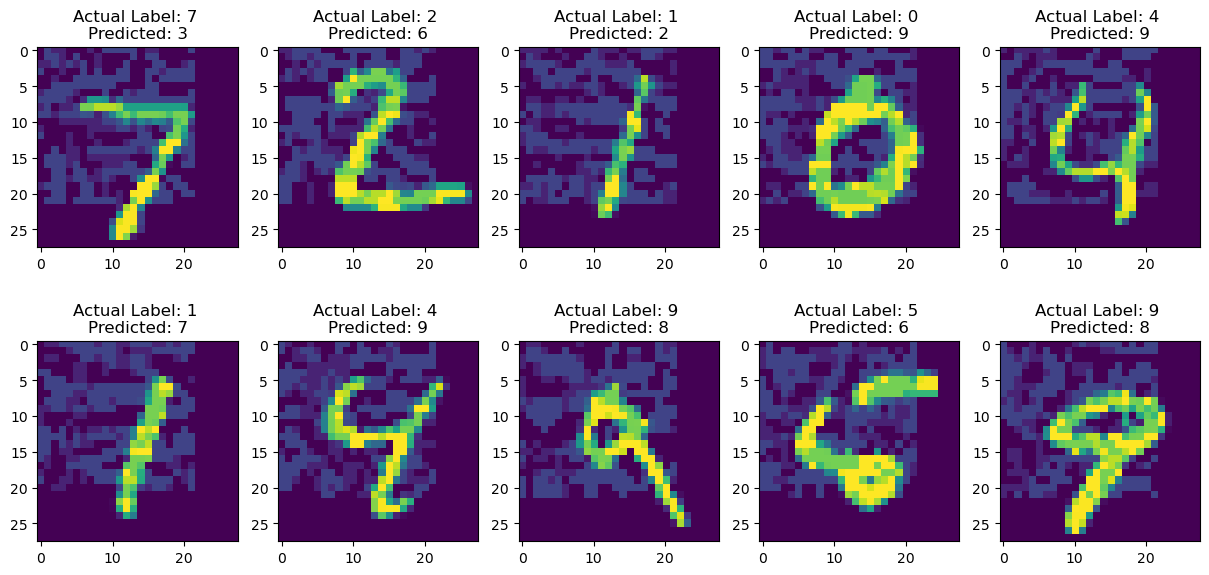

In [35]:
fig, ax = plt.subplots(2,5, figsize=(15, 7))
ax = ax.flatten()


for i, (image, label) in enumerate(zip(x_test_adv[:10], y_test[:10])):
  #im_idx = np.argwhere(y_train == i)[0]
  ax[i].imshow(image)
  ax[i].set_title(f"Actual Label: {label.argmax()} \nPredicted: {model.predict(np.expand_dims(image, axis=0)).argmax()}",  fontsize=12)


## Evaluate the trained model

In [36]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 5.20%
Average perturbation: 0.07


<br>

# Training the adversarial sample detector

In [24]:
# creating new adversarial using the pgd.
# we combine the generated adversarial images with the same number of images from the dataset and label them as [1, 0]
x_train_adv = attack_pgd.generate(x_train[:5000])
nb_train = x_train[:5000].shape[0]

x_train_detector = np.concatenate((x_train[:5000], x_train_adv), axis=0)
y_train_detector = np.concatenate((np.array([[1,0]]*nb_train), np.array([[0,1]]*nb_train)), axis=0)

PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


## Save/load the the adversarial samples

In [27]:
# np.savez('./pgd_generated_data/pgd_detector_generated_MNIST10.npz', 
#          x_train_detector=x_train_detector, y_train_detector = y_train_detector)

In [37]:
detector_data = np.load('./pgd_generated_data/pgd_detector_generated_MNIST10.npz')
x_train_detector, y_train_detector= detector_data['x_train_detector'], detector_data['y_train_detector']
x_train_detector.shape, y_train_detector.shape

((10000, 28, 28, 1), (10000, 2))

## Train and evaluate the detector model

In [23]:
detector_model = tf.keras.models.Sequential([
    # tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu', strides = 1),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

detector_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']);

In [24]:
# history = detector_model.fit(x_train_detector, y_train_detector, epochs = 3)

Train on 10000 samples
Epoch 1/3
   32/10000 [..............................] - ETA: 26s - loss: 0.6860 - accuracy: 0.5312

2024-05-15 14:16:26.134421: W tensorflow/c/c_api.cc:291] Operation '{name:'training_2/Adam/dense_4/bias/m/Assign' id:1677 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_4/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_4/bias/m, training_2/Adam/dense_4/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


10000/10000 [==============================] - 1s 82us/sample - loss: 0.0481 - accuracy: 0.9799
Epoch 2/3
10000/10000 [==============================] - 1s 62us/sample - loss: 4.3669e-05 - accuracy: 1.0000
Epoch 3/3
10000/10000 [==============================] - 1s 59us/sample - loss: 3.7063e-05 - accuracy: 1.0000


In [29]:
# Save and load the detector model
path = './../models/PGD_detector_model_mnist10.keras'
# detector_model.save(path)
detector_model =tf.keras.models.load_model(path)
detector_model.summary()

2024-05-15 14:19:44.813264: W tensorflow/c/c_api.cc:291] Operation '{name:'conv2d_7_3/bias/Assign' id:2853 op device:{requested: '', assigned: ''} def:{{{node conv2d_7_3/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_7_3/bias, conv2d_7_3/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-15 14:19:45.102731: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_4_3/bias/m/Assign' id:3131 op device:{requested: '', assigned: ''} def:{{{node dense_4_3/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_4_3/bias/m, dense_4_3/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 128)       

In [38]:
# creating the test samples using the previous created adversarial images with same number of images from the test_split
nb_test = x_test.shape[0]

x_test_detector = np.concatenate((x_test, x_test_adv), axis=0)
y_test_detector = np.concatenate((np.array([[1,0]]*nb_test), np.array([[0,1]]*nb_test)), axis=0)

Evaluat the result

In [39]:
loss_test, accuracy_test = detector_model.evaluate(x_test_detector, y_test_detector)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

2024-05-15 14:25:40.529429: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_6/mul' id:3061 op device:{requested: '', assigned: ''} def:{{{node loss_6/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_6/mul/x, loss_6/dense_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on test data: 100.00%


In [40]:
detector_classifier = KerasClassifier(clip_values=(0.0, 0.1), model=detector_model, use_logits=False)
detector = BinaryInputDetector(detector_classifier)

In [41]:
detector.fit(x_train_detector, y_train_detector, nb_epochs=3, batch_size=32)

2024-05-15 14:25:51.299119: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_6/mul' id:3061 op device:{requested: '', assigned: ''} def:{{{node loss_6/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_6/mul/x, loss_6/dense_5_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


## Evaluating the detector

Apply the detector to the adversarial test data:

In [43]:
_, is_adversarial = detector.detect(x_test_adv)
flag_adv = np.sum(is_adversarial)

print("Adversarial test data (first 100 images):")
print("Flagged: {}".format(flag_adv))
print("Not flagged: {}".format(1000 - flag_adv))

Adversarial test data (first 100 images):
Flagged: 500
Not flagged: 500


Apply the detector to the first 100 original test images:

In [44]:
_, is_adversarial = detector.detect(x_test[:100])
flag_original = np.sum(is_adversarial)

print("Original test data (first 100 images):")
print("Flagged: {}".format(flag_original))
print("Not flagged: {}".format(100 - flag_original))

Original test data (first 100 images):
Flagged: 0
Not flagged: 100


Evaluate the detector for different attack strengths eps (Note: for the training of detector, eps=0.25 was used)

In [45]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_flag_adv = []
nb_missclass = []


for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test[:100])
    nb_flag_adv += [np.sum(detector.detect(x_test_adv)[1])]
    nb_missclass += [np.sum(np.argmax(classifier.predict(x_test_adv), axis=1) != np.argmax(y_test[:100], axis=1))]

eps_range = [0] + eps_range
nb_flag_adv = [flag_original] + nb_flag_adv
nb_missclass = [2] + nb_missclass

PGD - Random Initializations: 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


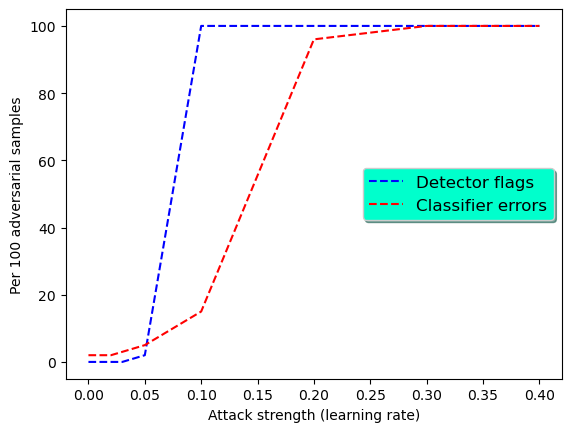

In [46]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range)[:10], np.array(nb_flag_adv)[:10], 'b--', label='Detector flags')
ax.plot(np.array(eps_range)[:10], np.array(nb_missclass)[:10], 'r--', label='Classifier errors')

legend = ax.legend(loc='center right', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (learning rate)')
plt.ylabel('Per 100 adversarial samples')
plt.show()

## **Summary of PGD Attack Implementation on MNIST10**


Overview

I have implemented the Projected Gradient Descent (PGD) attack on the MNIST10 dataset, which consists of handwritten digits from 0 to 9. The PGD attack is a widely-used adversarial attack method designed to test the robustness of machine learning models, particularly deep neural networks, against adversarial examples. This summary aims to explain the workings of the PGD attack, its implementation, and the impact of the perturbation magnitude (epsilon, ε) on the effectiveness of the attack.

#### **PGD Attack Mechanism**

The PGD attack is an iterative method that generates adversarial examples by applying small perturbations to the input data. The goal is to make these perturbed inputs cause the model to produce incorrect outputs while remaining visually similar to the original inputs. The key steps of the PGD attack are as follows:

1. **Initialization**: Start with an original input sample xx from the dataset.
2. **Perturbation**: Add a small, carefully chosen perturbation ηη to the input xx such that the new input x′=x+ηx′=x+η misleads the model. The perturbation is bounded by a parameter ϵϵ (epsilon), which controls the maximum allowed distortion.
3. **Iterative Optimization**: Apply gradient ascent iteratively to maximize the model's loss with respect to the input x′x′. After each iteration, project x′x′ back into the ϵϵ-ball around xx to ensure the perturbation remains within the specified bounds.

Mathematically, the PGD attack can be formulated as:
xt+1′=clipx,ϵ(xt′+α⋅sign(∇xL(θ,xt′,y)))xt+1′​=clipx,ϵ​(xt′​+α⋅sign(∇x​L(θ,xt′​,y)))
where clipx,ϵclipx,ϵ​ projects the perturbed input back into the ϵϵ-ball around xx, αα is the step size, ∇xL(θ,xt′,y)∇x​L(θ,xt′​,y) is the gradient of the loss with respect to the input, and LL is the loss function.

#### **Impact of Epsilon (ε)**

The parameter ϵϵ plays a critical role in determining the effectiveness of the PGD attack. It defines the maximum amount of perturbation allowed for each input. The impact of ϵϵ can be summarized as follows:

* Small ϵϵ: When ϵϵ is small, the perturbations are minimal, and the adversarial examples remain very close to the original inputs. This might lead to limited success in fooling the model, especially if the model is robust to small perturbations.
* Large ϵϵ: As ϵϵ increases, the perturbations become more noticeable, potentially making the adversarial examples more effective in causing misclassification. However, very large ϵϵ values can result in perturbed inputs that no longer resemble the original data, which may be unrealistic in practical scenarios.

The trade-off is to find an optimal ϵϵ that balances the attack's success rate and the visual similarity of the adversarial examples to the original inputs.

#### **Results and Observations**

In the implementation on the MNIST10 dataset, varying ϵϵ values demonstrated the following:

* Low ϵϵ (e.g., 0.1): The model's accuracy drops slightly, indicating that minor perturbations are not significantly affecting the model's predictions.
* Moderate ϵϵ (e.g., 0.3): The model's accuracy decreases more substantially, suggesting that the adversarial examples are effectively misleading the model.
* High ϵϵ (e.g., 0.5): The model's accuracy drops drastically, but the perturbations become more visible, potentially compromising the adversarial example's subtlety.

#### **Conclusion**

The PGD attack on MNIST10 illustrates the vulnerability of neural networks to adversarial examples and highlights the importance of robust model training. The choice of ϵϵ is crucial, as it influences both the effectiveness of the attack and the perceptual similarity of the adversarial examples to the original inputs. By experimenting with different ϵϵ values, one can understand the trade-offs involved and work towards developing more resilient machine learning models.